# Run Zernike Estimation on AuxTel runs

Author: Bryce Kalmbach

Date: 02-02-2023

This notebook shows how to run the WEP pipeline on AuxTel data and save the output in the butler repository.

In [1]:
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
%matplotlib inline

## Get AuxTel raw data

Get the latest AuxTel data found in `/repo/embargo`

In [2]:
repo_dir = '/repo/embargo/'

In [3]:
butler = Butler(repo_dir)

In [4]:
butler.registry.queryCollections()

['LATISS/raw/all',
 'LATISS/calib/DM-28636/curated/19700101T000000Z',
 'LATISS/calib/DM-28636/curated/20180101T000000Z',
 'LATISS/calib/DM-28636/unbounded',
 'refcats/DM-28636',
 'refcats/DM-33444',
 'skymaps',
 'u/czw/DM-28920/biasGen.20210702a/20210702T215049Z',
 'u/czw/DM-28920/darkGen.20210707d/20210707T215331Z',
 'u/czw/DM-28920/defectGen.20210720a/20210720T230634Z',
 'u/czw/DM-28920/flatGen.20210720Xa/20210720T223935Z',
 'u/czw/DM-28920/flatGen.20210720Xb/20210720T225330Z',
 'u/czw/DM-32209/flatGen.20211013a-felh/20211013T214128Z',
 'u/czw/DM-32209/flatGen.20211013a-g/20211013T185808Z',
 'u/edennihy/DM-33875/flatGen.20220303a-SDSSi/20220303T213603Z',
 'u/edennihy/DM-33875/flatGen.20220303b-SDSSr/20220303T194524Z',
 'LATISS/calib/DM-28636',
 'LATISS/calib/DM-33875',
 'u/calib/DM-32209-20211013a-felh',
 'u/calib/DM-32209-20211013a-g',
 'u/czw/DM-28920/calib/bias.20210720',
 'u/czw/DM-28920/calib/dark.20210720a',
 'u/czw/DM-28920/calib/defect.20210720a',
 'u/czw/DM-28920/calib/flat.

Find the exposures.

In [5]:
dataIds = list(butler.registry.queryDataIds(['exposure', 'detector'], collections='LATISS/raw/all', datasets='raw', instrument="LATISS", where='exposure.day_obs IN ( 20230201)'))

In [17]:
dataIds = list(butler.registry.queryDataIds(['exposure', 'detector'], collections='LATISS/runs/quickLook', datasets='quickLookExp', instrument="LATISS", where='exposure.day_obs IN ( 20230201)'))

In [19]:
dataIds

[{instrument: 'LATISS', detector: 0, exposure: 2023020100001, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100002, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100003, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100004, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100005, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100006, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100007, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100008, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100009, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100010, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100011, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100012, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100013, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2023020100014, ...},
 {instrument: 'LATISS', detector: 0, exposure: 2

From the [night log for 2/1/2023](https://confluence.lsstcorp.org/display/LSSTCOM/2023-02-01+AuxTel+NightLog) we can see that first CWFS run had exposures 303-307. We try to get data from this set of images with 303 and 304.

In [4]:
butler = Butler('/repo/embargo/',
                          collections=['LATISS/raw/all', 'LATISS/calib/unbounded', 'LATISS/runs/quickLook'])
datasetRefOrType='raw'
year='2023'
monthDay='0201'

exp_short_num_1 = '00303'
data_id_1 = dataId={'instrument':'LATISS', 'detector':0, 'exposure':int(f'{year}{monthDay}{exp_short_num_1}')}
exposure_1 =  butler.get(datasetRefOrType, dataId=data_id_1, )

exp_short_num_2 = '00304' 
data_id_2 = dataId={'instrument':'LATISS', 'detector':0, 'exposure':int(f'{year}{monthDay}{exp_short_num_2}')}
exposure_2 = butler.get(datasetRefOrType, dataId=data_id_2,)

camera = butler.get('camera', {'instrument': 'LATISS'})

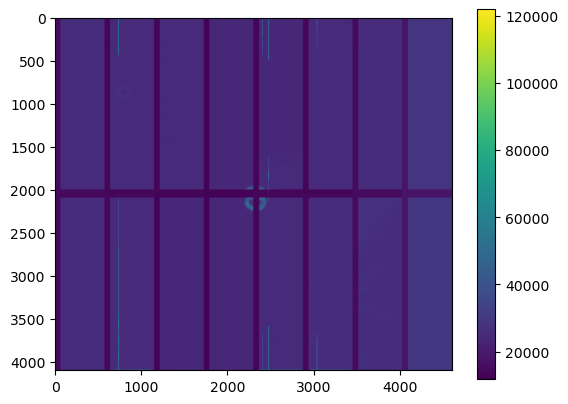

In [8]:
# Take a look at one of the images.
plt.imshow(exposure_1.image.array, )
plt.colorbar()

We have two images but we don't know which is intra-focal and which is extra. Look at `visitInfo.focusZ` to find this info.

In [9]:
print(exposure_1.visitInfo.focusZ, exposure_2.visitInfo.focusZ)

0.800000011920929 -0.801099956035614


`exposure_1` has a positive `focusZ` values meaning it is the intra-focal image and `exposure_2` is the extra-focal image.

## Run ISR

If the images don't have ISR run and aren't available as `quickLookExp` in the repository yet we can make 

In [10]:
from lsst.summit.utils import BestEffortIsr
best_effort_isr = BestEffortIsr(embargo=True)

In [11]:
exp_intra = best_effort_isr.getExposure(data_id_1)
exp_extra = best_effort_isr.getExposure(data_id_2)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-5.1.0/Linux64/obs_base/gdadf9dca80+ee6e69aab3/python/lsst/obs/base/formatters/fitsExposure.py:643: UserWarning: Reading file:///tmp/tmpp4hmbqdk.fits with data ID {instrument: 'LATISS', detector: 0, physical_filter: 'empty~empty', ...}: filter label mismatch (file is None, data ID is FilterLabel(band="white", physical="empty~empty")).  This is probably a bug in the code that produced it.
  warnings.warn(


Text(0.5, 1.0, 'Extra-focal postISR')

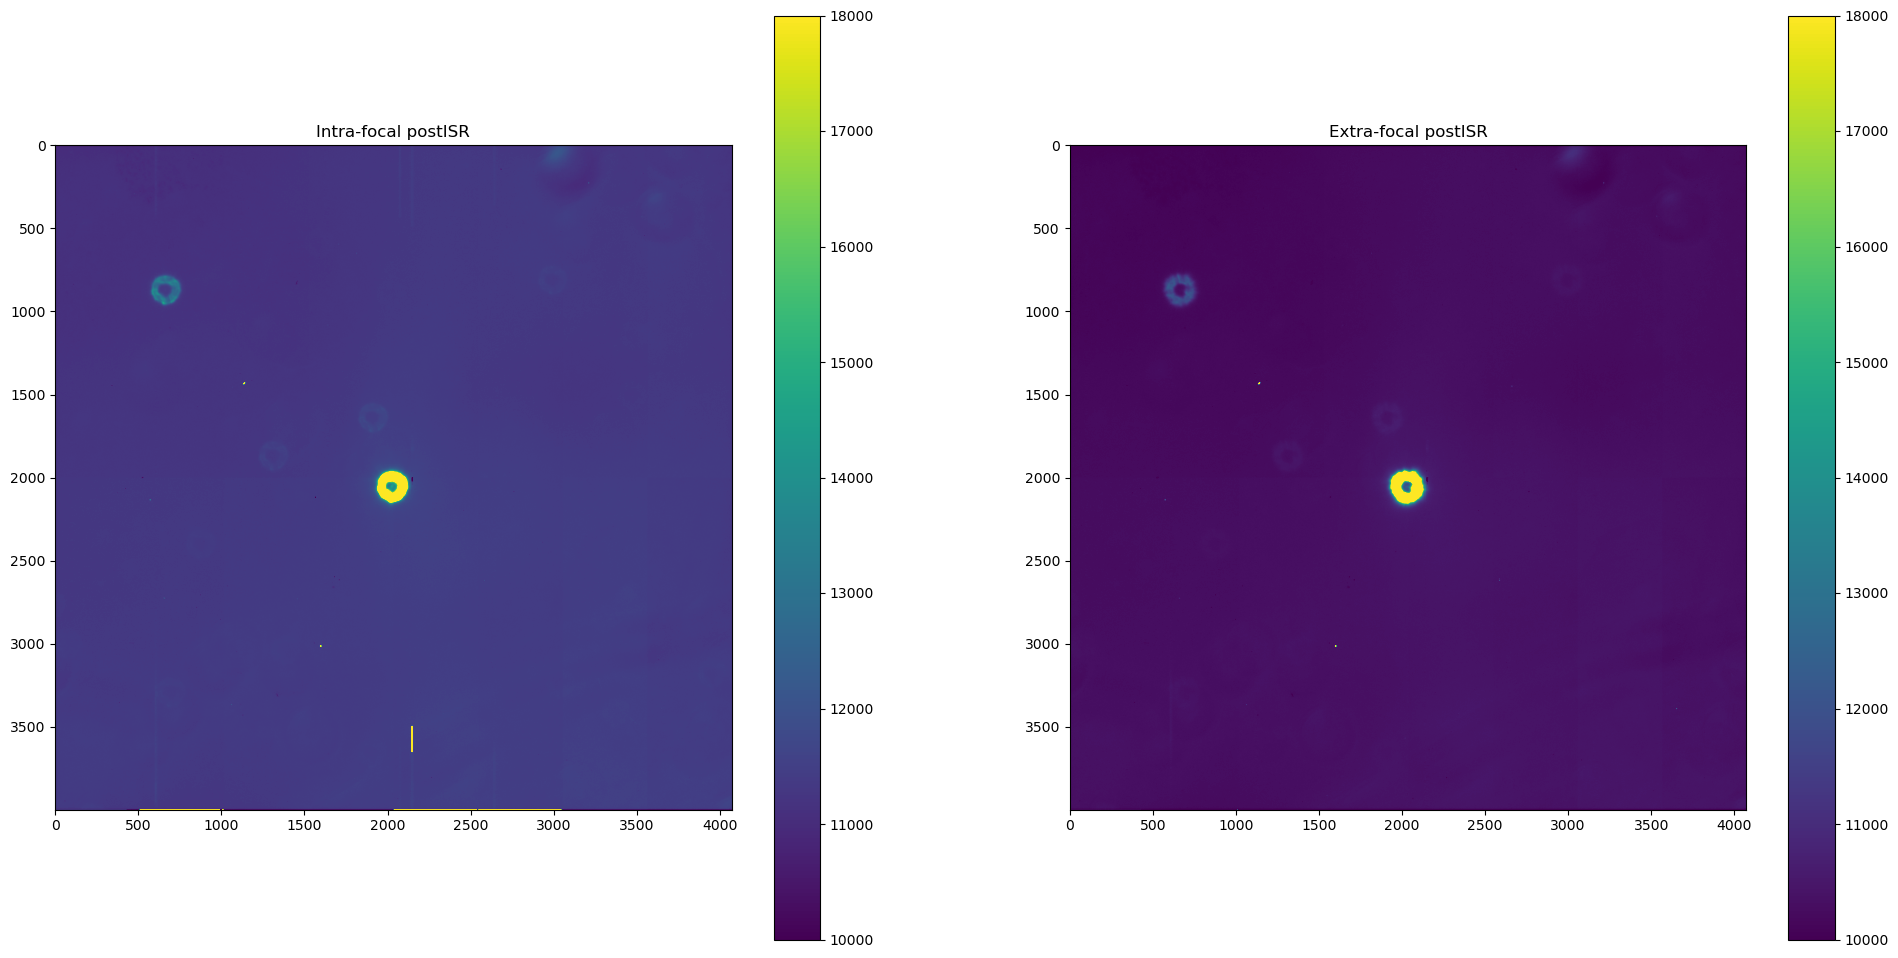

In [14]:
%matplotlib inline

fig=plt.figure(figsize=(24,12))
fig.add_subplot(1,2,1)
plt.imshow(exp_intra.image.array, vmin=10000, vmax=18000)
plt.colorbar()
plt.title('Intra-focal postISR')

fig.add_subplot(1,2,2)
plt.imshow(exp_extra.image.array, vmin=10000, vmax=18000)
plt.colorbar()
plt.title('Extra-focal postISR')

In [26]:
data_id_1

{'instrument': 'LATISS', 'detector': 0, 'exposure': 2023020100303}

In [24]:
! pipetask run -b /repo/embargo/ -i LATISS/raw/all,LATISS/calib --instrument lsst.obs.lsst.Latiss --register-dataset-types --output-run u/brycek/DM-37838 -p latissWepPipeline.yaml -d "exposure in (2023020100303, 2023020100304)"

lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 7 quanta for 4 tasks, graph ID: '1675409132.8654768-11832'
Quanta             Tasks            
------ -----------------------------
     2                           isr
     2 generateDonutDirectDetectTask
     1 cutOutDonutsScienceSensorTask
     2              calcZernikesTask
py.warnings WARNING: /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-5.1.0/Linux64/obs_base/gdadf9dca80+ee6e69aab3/python/lsst/obs/base/formatters/fitsExposure.py:643: UserWarning: Reading file:///tmp/tmpt0js1fb2.fits with data ID {instrument: 'LATISS', detector: 0, physical_filter: 'empty~empty', ...}: filter label mismatch (file is None, data ID is FilterLabel(band="white", physical="empty~empty")).  This is probably a bug in the code that produced it.
  warnings.warn(

lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Applying bias correction.
lsst.isr INFO: Masking defects.


In [5]:
data_id_1['visit'] = data_id_1['exposure']
data_id_2['visit'] = data_id_2['exposure']

In [6]:
data_id_intra = data_id_1
data_id_extra = data_id_2

In [7]:
# Reload butler to get new collection
butler = Butler(repo_dir)

In [8]:
list(butler.registry.queryDataIds(['exposure', 'visit', 'detector'], datasets='zernikeEstimateRaw', collections='u/brycek/DM-37838'))

[{instrument: 'LATISS', detector: 0, exposure: 2023020100304, visit: 2023020100304, ...}]

In [9]:
data_id_1

{'instrument': 'LATISS',
 'detector': 0,
 'exposure': 2023020100303,
 'visit': 2023020100303}

In [10]:
zernOut = butler.get('zernikeEstimateRaw', dataId=data_id_extra, collections='u/brycek/DM-37838')

In [11]:
donutCatExtra = butler.get('donutCatalog', dataId=data_id_extra, collections='u/brycek/DM-37838')

In [12]:
donutCatIntra = butler.get('donutCatalog', dataId=data_id_intra, collections='u/brycek/DM-37838')

In [13]:
postIsrExtra = butler.get('postISRCCD', dataId=data_id_extra, collections='u/brycek/DM-37838')
postIsrIntra = butler.get('postISRCCD', dataId=data_id_intra, collections='u/brycek/DM-37838')

Text(0, 0.5, 'Zernike Values (microns)')

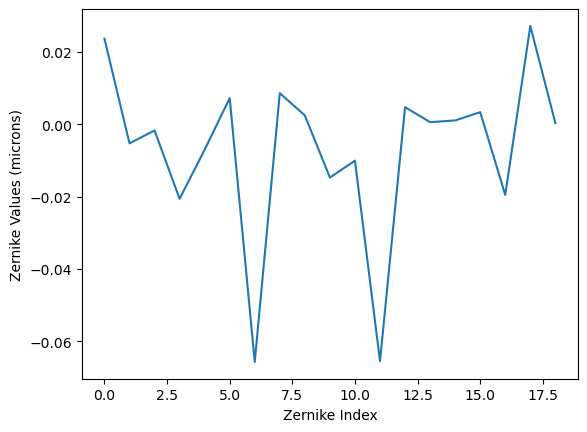

In [14]:
plt.plot(zernOut[0])
plt.xlabel('Zernike Index')
plt.ylabel('Zernike Values (microns)')

In [15]:
donutCatIntra

,coord_ra,coord_dec,centroid_x,centroid_y,detector,source_flux,blend_centroid_x,blend_centroid_y
0,1.732556,-0.454114,2028.89696,2053.98171,RXX_S00,2.317241e+08,[],[]


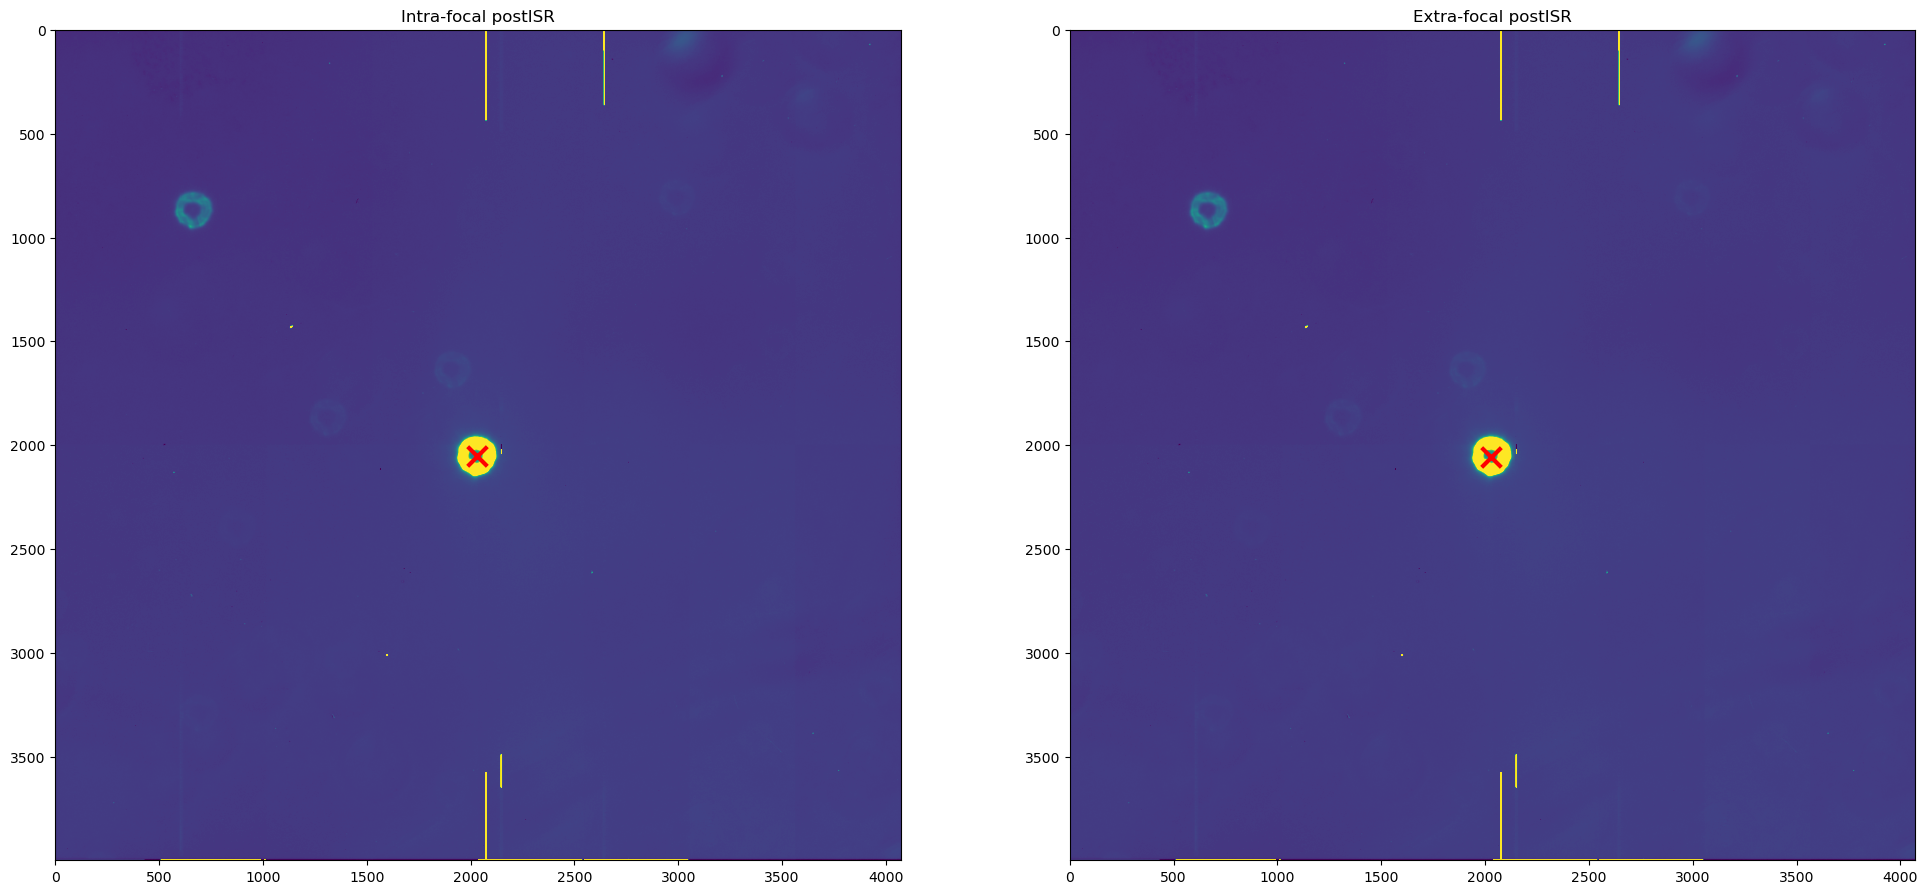

In [16]:
%matplotlib inline

fig=plt.figure(figsize=(24,12))
fig.add_subplot(1,2,1)
plt.imshow(postIsrIntra.image.array, vmin=10000, vmax=18000)
#plt.colorbar()
plt.title('Intra-focal postISR')
plt.scatter(donutCatIntra['centroid_x'], donutCatIntra['centroid_y'], c='r', marker='x', lw=3, s=200)

fig.add_subplot(1,2,2)
plt.imshow(postIsrIntra.image.array, vmin=10000, vmax=18000)
#plt.colorbar()
plt.title('Extra-focal postISR')
plt.scatter(donutCatExtra['centroid_x'], donutCatExtra['centroid_y'], c='r', marker='x', lw=3, s=200)

In [17]:
donutStampsExtra = butler.get('donutStampsExtra', dataId=data_id_extra, collections='u/brycek/DM-37838')

In [18]:
donutStampsIntra = butler.get('donutStampsIntra', dataId=data_id_extra, collections='u/brycek/DM-37838')

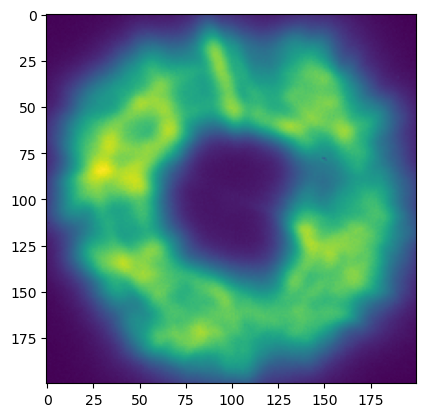

In [19]:
plt.imshow(donutStampsExtra[0].stamp_im.image.array)

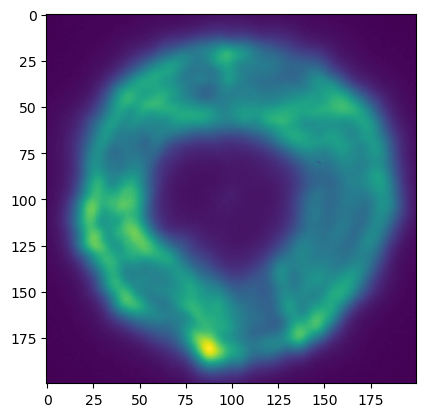

In [20]:
plt.imshow(donutStampsIntra[0].stamp_im.image.array)

In [23]:
# ! butler remove-runs /repo/embargo/ u/brycek/DM-37838 --no-confirm

The following RUN collections were removed:
u/brycek/DM-37838
The following datasets were removed:
calcZernikesTask_config(1), calcZernikesTask_log(2), calcZernikesTask_metadata(2), cutOutDonutsScienceSensorTask_config(1), cutOutDonutsScienceSensorTask_log(1), cutOutDonutsScienceSensorTask_metadata(1), donutCatalog(2), donutStampsExtra(1), donutStampsIntra(1), generateDonutDirectDetectTask_config(1), generateDonutDirectDetectTask_log(2), generateDonutDirectDetectTask_metadata(2), isr_config(1), isr_log(2), isr_metadata(2), packages(1), postISRCCD(2), zernikeEstimateAvg(1), zernikeEstimateRaw(1)
